# scPipe-Multimodal Seurat

In [1]:
# if (!requireNamespace("BiocManager", quietly = TRUE)) install.packages("BiocManager")
# BiocManager::install(c("harmony"))
# BiocManager::install(c("glmGamPoi"))
# BiocManager::install('limma')

# install.packages("Seurat")
# install.packages("sctransform")

# install.packages('devtools')
# devtools::install_github('immunogenomics/presto')

In [1]:
# Library import

library(Seurat)
library(ggplot2)
library(sctransform)
library(harmony)
library(patchwork)
library(dplyr)
library(magrittr)

set.seed(1)

# Multicore CPU usage activation - Future
library(future)

plan("multicore", workers = 10) 
# Set RAM Size to 3/4 of total RAM
options(future.globals.maxSize = 16000 * 1024^2)

future.seed=TRUE # Removes future-generated statistical errors

Warning message:
“пакет ‘Seurat’ был собран под R версии 4.3.3”
Загрузка требуемого пакета: SeuratObject

Warning message:
“пакет ‘SeuratObject’ был собран под R версии 4.3.3”
Загрузка требуемого пакета: sp


Присоединяю пакет: ‘SeuratObject’


Следующие объекты скрыты от ‘package:base’:

    intersect, t


Загрузка требуемого пакета: Rcpp

Warning message:
“пакет ‘Rcpp’ был собран под R версии 4.3.3”
Warning message:
“пакет ‘patchwork’ был собран под R версии 4.3.3”

Присоединяю пакет: ‘dplyr’


Следующие объекты скрыты от ‘package:stats’:

    filter, lag


Следующие объекты скрыты от ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“пакет ‘future’ был собран под R версии 4.3.3”


In [2]:
library(data.table)
# Load data
cell_by_gene <- fread("cell_by_gene.csv", data.table = FALSE)
cell_metadata <- fread("cell_metadata.csv", data.table = FALSE)

# Extract cell barcodes and gene names
cell_barcodes <- cell_by_gene[, 1]  # First column contains cell barcodes
gene_names <- colnames(cell_by_gene)[-1]  # Gene names are column names

# Ensure unique gene names
gene_names <- make.unique(gene_names)  

# Transpose matrix
cell_by_gene <- t(cell_by_gene[, -1])  # Remove first column (cell barcodes) before transposing

# Assign correct row & col names
rownames(cell_by_gene) <- gene_names  # Genes as row names
colnames(cell_by_gene) <- make.unique(cell_barcodes)  # Ensure unique cell names

# Convert to matrix
cell_by_gene <- as.matrix(cell_by_gene)

# Create Seurat object
Seurat <- CreateSeuratObject(counts = cell_by_gene)

# Fix metadata cell names
cell_metadata$V1 <- gsub("_\\d+$", "", cell_metadata$V1)  # Remove suffixes like "_10" if needed
rownames(cell_metadata) <- make.unique(cell_metadata$V1)  # Ensure unique rownames

# Remove first column from metadata
cell_metadata <- cell_metadata[, -1]

# Check if names match
print(all(rownames(cell_metadata) %in% colnames(Seurat)))  # Should return TRUE

# Add metadata
Seurat <- AddMetaData(Seurat, metadata = cell_metadata)

Seurat

Warning message:
“пакет ‘data.table’ был собран под R версии 4.3.3”

Присоединяю пакет: ‘data.table’


Следующие объекты скрыты от ‘package:dplyr’:

    between, first, last


Warning message:
“Data is of class matrix. Coercing to dgCMatrix.”


[1] FALSE


An object of class Seurat 
2711 features across 27313 samples within 1 assay 
Active assay: RNA (2711 features, 0 variable features)
 1 layer present: counts

In [3]:
head(Seurat@meta.data)

,orig.ident,nCount_RNA,nFeature_RNA,center_x,center_y,z,fov,volume
,<fct>,<dbl>,<int>,<dbl>,<dbl>,<int>,<int>,<int>
AACAGGAAGAGCATAG-1_9_1,SeuratProject,2,2,2069.443,324.6453,0,0,80
AACAGGAAGAGCATAG-1_9_2,SeuratProject,2,2,2060.326,328.6394,0,0,80
AACAGGAAGAGCATAG-1_9_3,SeuratProject,2,2,2055.490,329.2307,0,0,80
AACAGGATTCATAGTT-1_12_1,SeuratProject,3,3,1697.058,722.8637,0,0,80
AACAGGATTCATAGTT-1_13_1,SeuratProject,11,11,1687.673,721.5955,0,0,80
AACAGGATTCATAGTT-1_13_2,SeuratProject,11,11,1691.943,715.8764,0,0,80


Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”
Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”


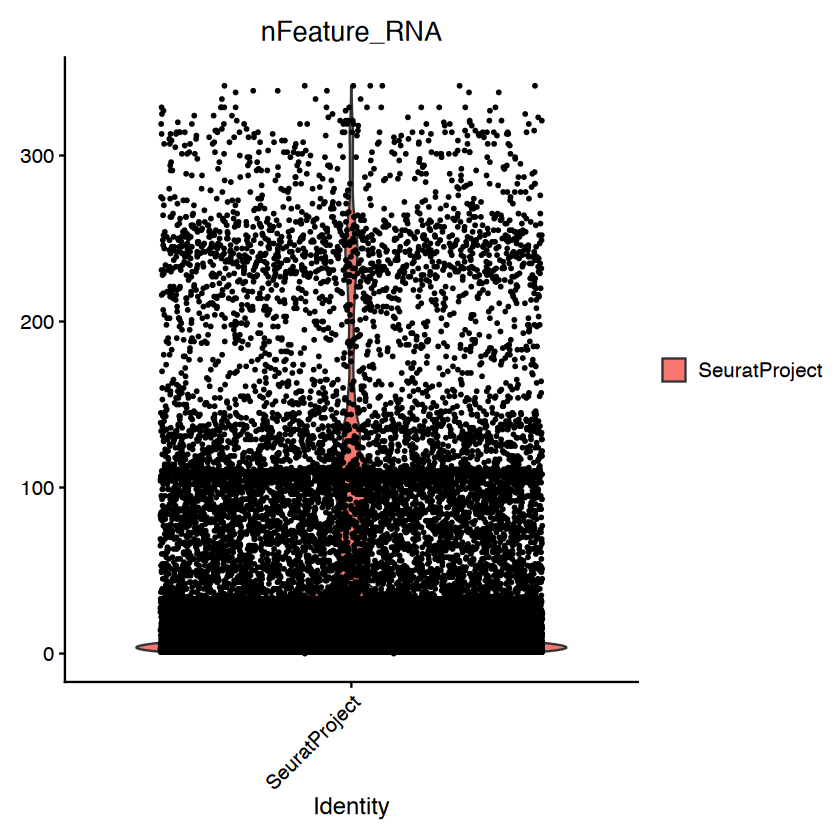

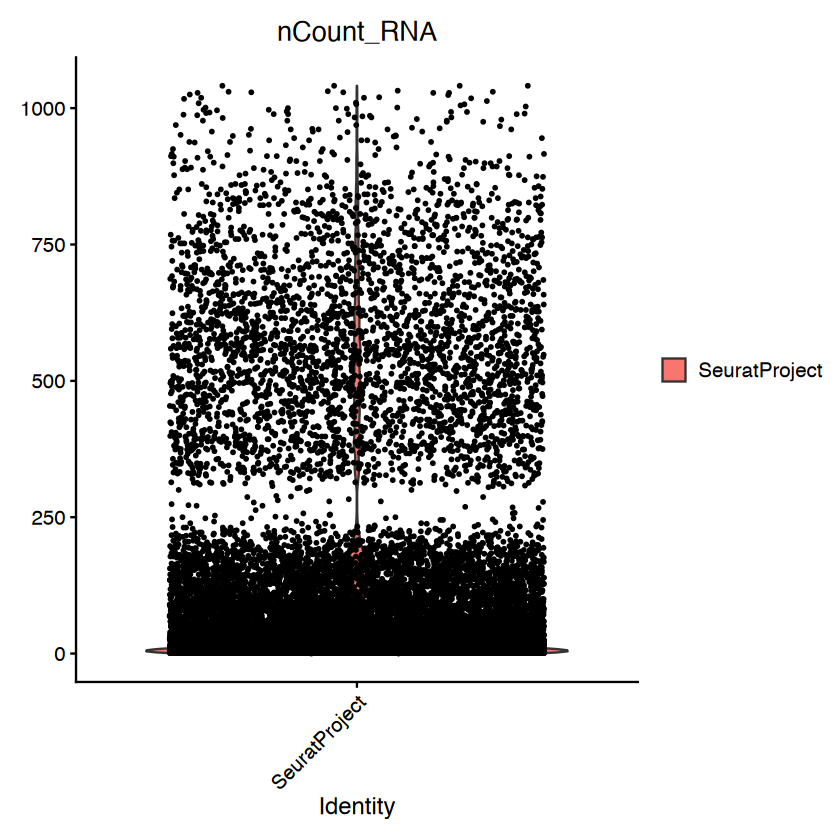

In [4]:
VlnPlot(Seurat, features = "nFeature_RNA")
VlnPlot(Seurat, features = "nCount_RNA")

An object of class Seurat 
2711 features across 27313 samples within 1 assay 
Active assay: RNA (2711 features, 0 variable features)
 1 layer present: counts

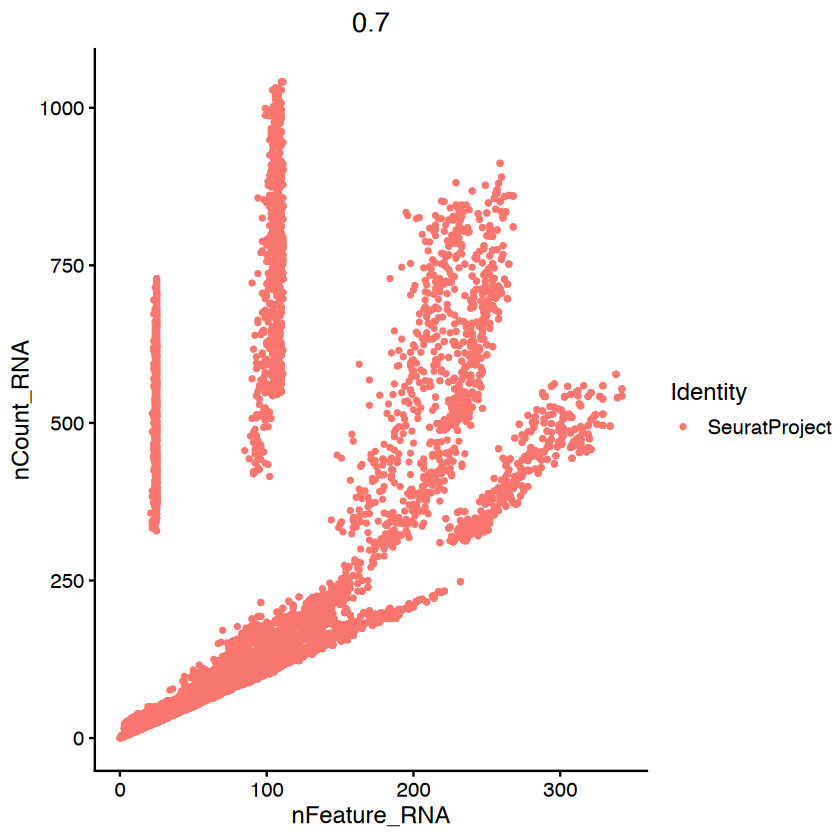

In [5]:
# Контроль качества при помощи FeatureScatter Plot

FeatureScatter(Seurat, feature2 = "nCount_RNA", feature1 = "nFeature_RNA")

Seurat

In [6]:
Seurat <- NormalizeData(Seurat, normalization.method = "LogNormalize", scale.factor = 10000)

Normalizing layer: counts



Finding variable features for layer counts

When using repel, set xnudge and ynudge to 0 for optimal results

Warning message:
“ggrepel: 8 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


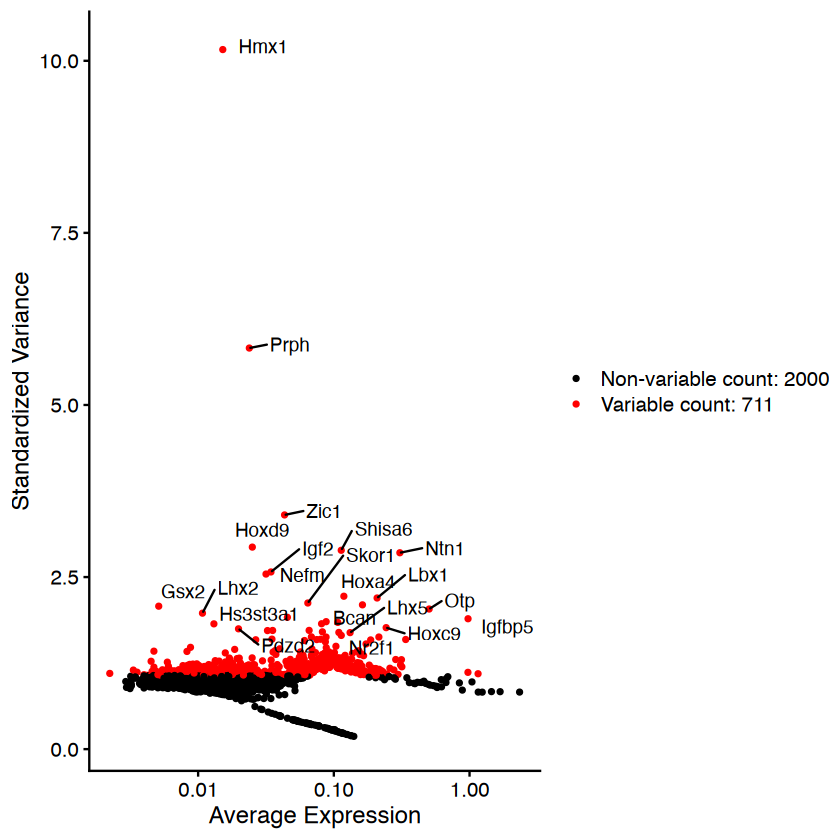

In [25]:
Seurat <- FindVariableFeatures(Seurat, selection.method = "vst", nfeatures = 711)

# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(Seurat), 30)

# plot variable features with and without labels
plot1 <- VariableFeaturePlot(Seurat)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)

plot2

In [26]:
all.genes <- rownames(Seurat)
Seurat <- ScaleData(Seurat, features = all.genes)

Centering and scaling data matrix



In [27]:
# Calculate PCs using variable features determined by SCTransform
Seurat <- RunPCA(Seurat, npcs = 40)

PC_ 1 
Positive:  Adgrb1, Zfp362, Ccdc124, Dctn1, Sh2b2, Mark4, Clta, Ncs1, Phf12, Nap1l1 
	   Ptpn12, Kat6a, Sept5, Fam193b, Irgq, Rnf187, Wdr26, Ywhag, Papola, Ndfip2 
	   Hoxb2, Ube2e3, Cacna1a, Anp32e, Pcbp4, Hdac11, Phldb1, Kansl2, Fmn2, Tmem259 
Negative:  Rundc3a, Slc22a17, Hdgfl2, Psd, Aplp1, Astn1, Brsk2, C1qtnf4, Hoxb5, Apc2 
	   Hnrnpa0, 2700081O15Rik, Dnlz, Soga3, Kif21b, Cpsf6, Mapk8ip1, Shank2, Ptpn5, Acly 
	   Cltb, Nrxn2, Limk2, Dach1, Cbfa2t3, Prr36, Lsm4, Gabrb3, Podxl2, Atxn2l 
PC_ 2 
Positive:  Taok2, Lix1l, Sirt2, Bicra, Prkcsh, Tubb2a, Macf1, Marcksl1, Rufy3, Amotl2 
	   Fbrs, Ciz1, Setbp1, Gramd1a, Col9a2, Sltm, Npdc1, Tacc2, Atp9a, Nsd2 
	   Mtus1, Carhsp1, Mex3d, Vangl2, Ly6h, Psap, Ppp1r16a, Vps33a, Vps37b, Ash1l 
Negative:  Adgrb1, Zfp362, Ccdc124, Mark4, Clta, Kat6a, Dctn1, Wdr26, Nap1l1, Fam193b 
	   Phf12, Sh2b2, Rnf187, Ncs1, Ptpn12, Irgq, Ywhag, Papola, Sept5, Fmn2 
	   Ndfip2, Hdac11, Anp32e, Ube2e3, Pcbp4, Phldb1, Cacna1a, Kansl2, Hoxb2, Tmem259 
PC_ 3

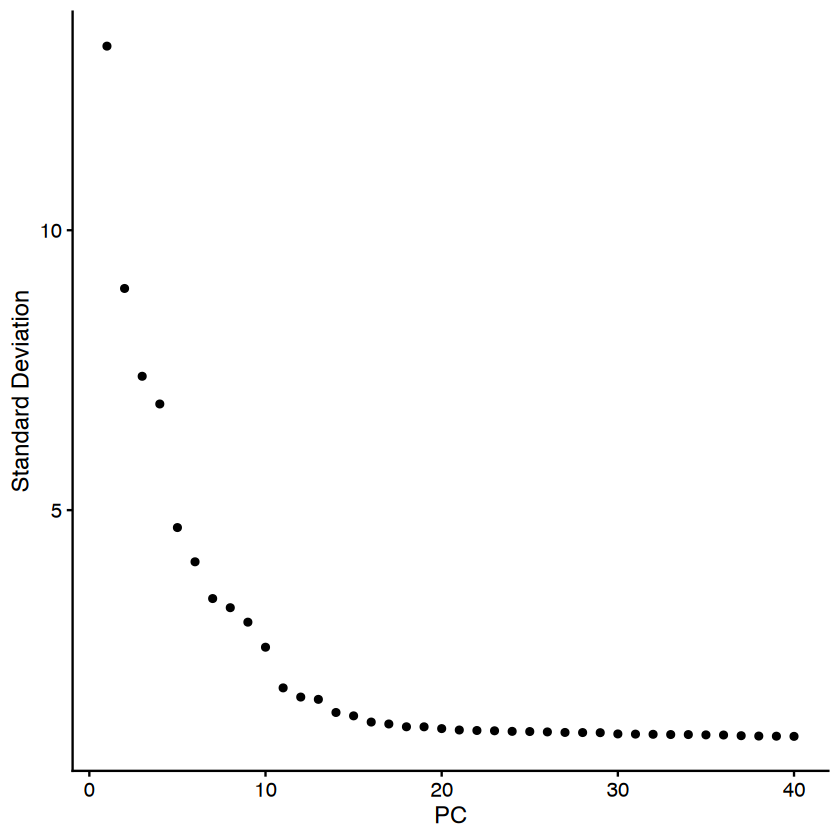

In [28]:
ElbowPlot(Seurat, ndims = 40)

In [29]:
dims = 19

Seurat <- FindNeighbors(Seurat, dims = 1:dims)
Seurat <- RunUMAP(Seurat, dims = 1:dims)

Computing nearest neighbor graph

Computing SNN

18:49:46 UMAP embedding parameters a = 0.9922 b = 1.112

18:49:46 Read 27313 rows and found 19 numeric columns

18:49:46 Using Annoy for neighbor search, n_neighbors = 30

18:49:46 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

18:49:48 Writing NN index file to temp file /var/folders/lk/54m90rgj1fqg895lxsgx1l180000gn/T//RtmpLj9XE7/filec66857e9b231

18:49:48 Searching Annoy index using 10 threads, search_k = 3000

18:49:48 Annoy recall = 34.98%

18:49:48 Commencing smooth kNN distance calibration using 10 threads
 with target n_neighbors = 30

18:49:48 19629 smooth knn distance failures

18:49:49 Found 9 connected components, 
falling back to 'spca' initialization with init_sdev = 1

18:49:49 Using 'irlba' for PCA

18:49

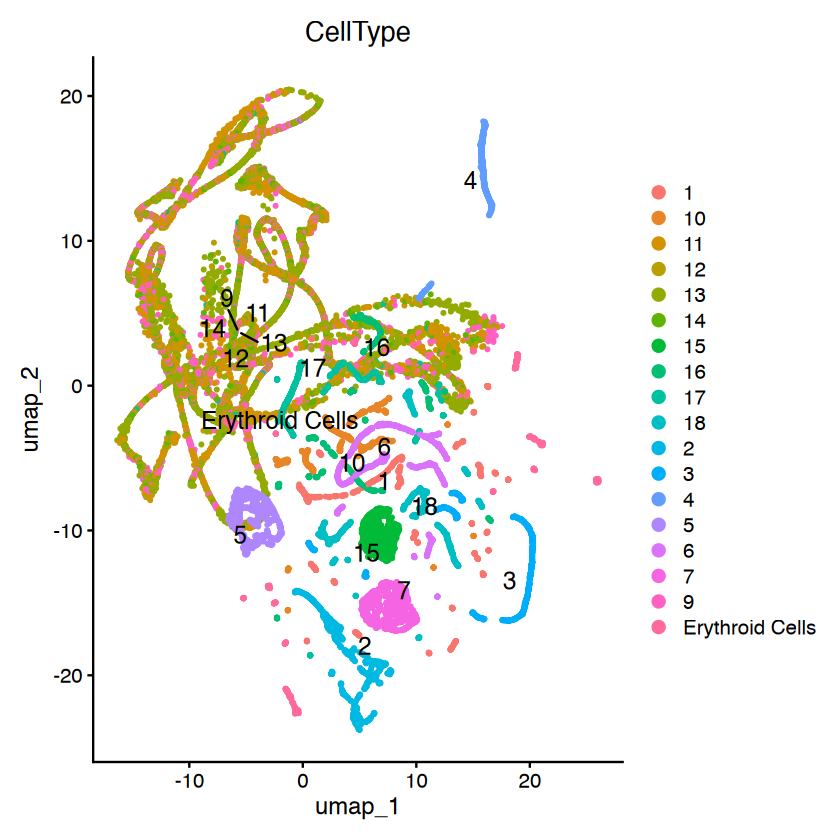

In [31]:
distance_clusters <- read.csv("cluster_info.csv")
Seurat <- AddMetaData(Seurat, metadata = distance_clusters$Cluster, col.name = "CellType")
Seurat <- SetIdent(Seurat, value = "CellType")

# Distance Clusters
DimPlot(Seurat, group.by = "CellType",
        label = TRUE, pt.size = 0.65, 
        label.size = 5, repel = TRUE)

In [55]:
Seurat

An object of class Seurat 
2711 features across 27313 samples within 1 assay 
Active assay: RNA (2711 features, 711 variable features)
 3 layers present: counts, data, scale.data
 2 dimensional reductions calculated: pca, umap

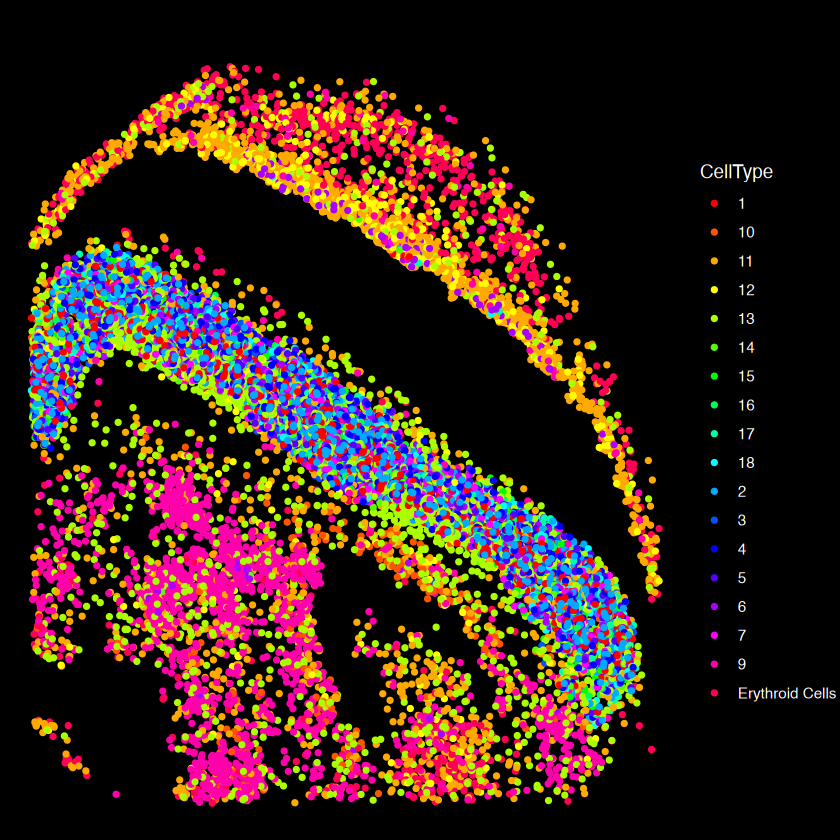

In [32]:
Seurat@meta.data$center_x <- as.numeric(Seurat@meta.data$center_x)
Seurat@meta.data$center_y <- as.numeric(Seurat@meta.data$center_y)

# Plot clusters with black background
ggplot(Seurat@meta.data, aes(x = center_x, y = center_y, color = as.factor(CellType))) +
  geom_point(size = 1) +
  scale_color_manual(values = rainbow(length(unique(Seurat$CellType)))) + # Custom colors
  theme_void() +  # Remove axis
  theme(panel.background = element_rect(fill = "black", color = "black"), 
        plot.background = element_rect(fill = "black"),
        legend.text = element_text(color = "white"),
        legend.title = element_text(color = "white")) +
  labs(title = "Spatial Plot of Clusters", color = "CellType")

ggsave(
  "Spatial Cluster Plot.pdf",
  plot = last_plot(),
  device = "pdf",
#   path = NULL,
#   scale = 1,
#   1 plot == 10 cm in each dimention
  width = 42,
  height = 40,
  units = "cm",
  dpi = 10000,
  limitsize = TRUE,
#   bg = NULL,
)

In [ ]:
# Seurat <- FindClusters(Seurat, algorithm = 3, 
#                        resolution = 0.01, verbose = FALSE)
# # Seurat Clusters
# DimPlot(Seurat, group.by = "seurat_clusters",
#         label = TRUE, pt.size = 0.65, 
#         label.size = 5, repel = TRUE)

In [19]:
# Seurat@meta.data$center_x <- as.numeric(Seurat@meta.data$center_x)
# Seurat@meta.data$center_y <- as.numeric(Seurat@meta.data$center_y)

# # Plot clusters with black background
# ggplot(Seurat@meta.data, aes(x = center_x, y = center_y, color = as.factor(seurat_clusters))) +
#   geom_point(size = 0.0001) +
#   scale_color_manual(values = rainbow(length(unique(Seurat$seurat_clusters)))) + # Custom colors
#   theme_void() +  # Remove axis
#   theme(panel.background = element_rect(fill = "black", color = "black"), 
#         plot.background = element_rect(fill = "black"),
#         legend.text = element_text(color = "white"),
#         legend.title = element_text(color = "white")) +
#   labs(title = "Spatial Plot of Clusters", color = "Cluster")

# ggsave(
#   "Spatial Cluster Plot.pdf",
#   plot = last_plot(),
#   device = "pdf",
# #   path = NULL,
# #   scale = 1,
# #   1 plot == 10 cm in each dimention
#   width = 42,
#   height = 40,
#   units = "cm",
#   dpi = 10000,
#   limitsize = TRUE,
# #   bg = NULL,
# )

In [48]:
levels(Seurat) <- c('Erythroid Cells ',
                    '1','2','3','4','5','6','7','9','10',
                    '11','12','13','14','15','16','17','18')

new.cluster.ids <- c('Erythroid Cells ',
                    '1','2','3','4','5','6','7','9','10',
                    '11','12','13','14','15','16','17','18')

names(new.cluster.ids) <- levels(Seurat)

Seurat <- RenameIdents(Seurat, new.cluster.ids)

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


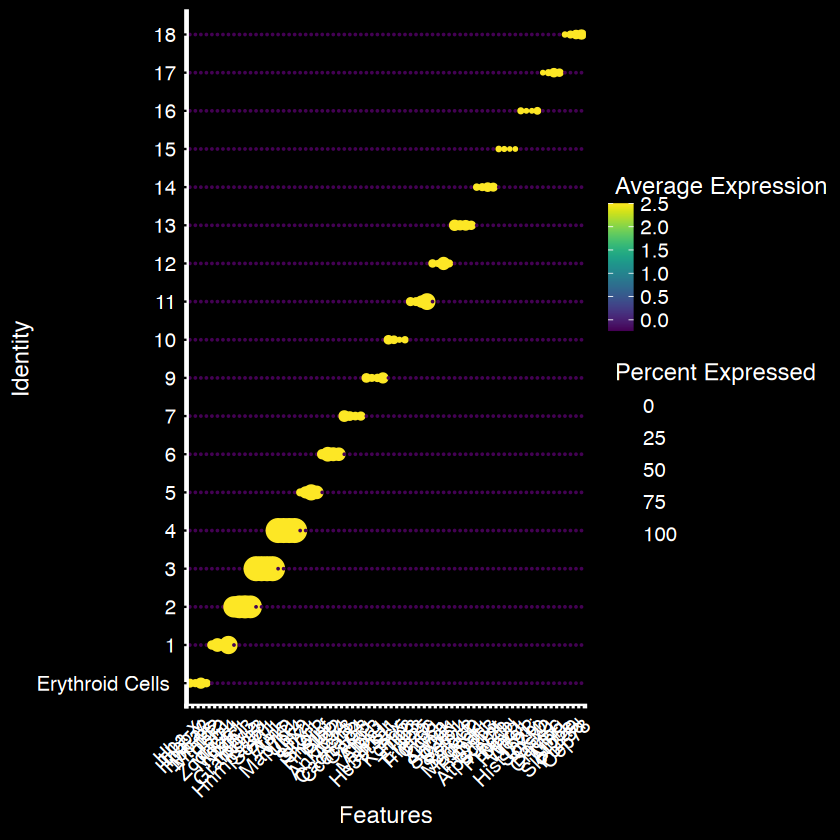

In [54]:
cluster_features = c('Hba-x','Hbb-y','Hba-a2','Hbb-bs', 
                     'Mthfd2', 'Ier2', 'Pag1', 'Zcchc24',
                     'Mdga1', 'Npdc1', 'Rufy3', 'Gramd1a',
                     'Pdia3', 'Hnrnpa2b1', 'Sox11', 'Yy1',
                     'Ptms', 'Ank2', 'Map7d1', 'Ubr4',
                     'Lhx2', 'Lhx1', 'Skor1', 'Skor2',
                     'Hnrnpf', 'Slbp', 'Pkd2', 'Ankrd54',
                     'Actr3', 'Cacna1b', 'Ccdc184', 'Gata3',
                     'Ryr1', 'Alpk3', 'Jph1', 'Mamstr',
                     'Hs3st3a1', 'Scx', 'Kcnq5', 'Trip6',
                     'Tjp3', 'Erbb3', 'Trim25', 'Clic6',
                     'Fdx1', 'Cyba', 'Ahnak', 'Slc2a1',
                     'Sntb1', 'Vstm4', 'Smoc2', 'Maged2',
                     'Nsl1', 'Rhbdf1', 'Efnb3', 'Atpsckmt',
                     'Kat2b', 'Prkacb', 'Dpyd', 'Pithd1',
                     'Wee1', 'Tbx2', 'Hist1h2bj', 'Sox10',
                     'Gsx2', 'Bace1', 'Chmp6', 'Lmf1',
                     'Atp5e', 'Slc12a9', 'Polr3d', 'Cep78')

library(viridis)
DotPlot(Seurat, features = cluster_features) + RotatedAxis() + scale_colour_viridis() +DarkTheme()

# Save the last plot as a pdf

ggsave(
  "Dot plot.pdf",
  plot = last_plot(),
  device = "pdf",
#   path = NULL,
#   scale = 1,
#   1 plot == 10 cm in each dimention
  width = 54,
  height = 20,
  units = "cm",
  dpi = 10000,
  limitsize = TRUE,
#   bg = NULL,
)

# Tip! Open PDF files in Pixelmator Pro and export them as 1x jpg for papers!